## Voxel Reconstruction 

In [3]:
from src.nerf_dataset import load_nerf_data, create_dataloader
import os
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.voxel_render_models import BaseObject, Camera, VolumetricRenderer

In [4]:
# Load the dataset
img_resize = 400
obj_name = "chair"
path = os.environ["DATASET_PATH"]
data_path = os.path.join(os.path.join(path, f"nerf_synthetic"),f"{obj_name}")
batch_size = 1024

train_rays_o, train_rays_d, train_pixels, pose, (w, h, f) = load_nerf_data(data_path, "train", obj_name, (img_resize, img_resize))
test_rays_o, test_rays_d, test_pixels, test_pose, _ = load_nerf_data(data_path, "test", obj_name, (img_resize, img_resize))

data_loader = create_dataloader(train_rays_o, train_rays_d, train_pixels, batch_size=batch_size, shuffle=True)

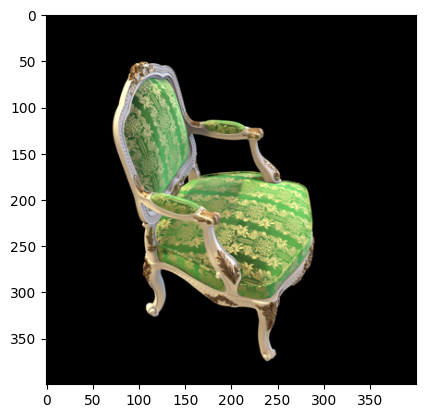

In [5]:
plt.imshow(test_pixels[30].reshape(h, w, 3).numpy())
plt.show()

In [6]:
# modified from cube
class Voxels(nn.Module, BaseObject):
    def __init__(self, n_voxels, size, device='cpu'):
        super().__init__()
        # for simplicity, assume that position is (0, 0, 0)
        self.n_voxels = n_voxels
        self.size = size
        
        # size [n, n, n, 4] for 3 colors + density
        # for better result on the black background image, intialize with ones. 
        self.voxels = torch.nn.Parameter(torch.ones((n_voxels, n_voxels, n_voxels, 4), requires_grad=True, device=device))
        # self.voxels = torch.nn.Parameter(torch.randn((n_voxels, n_voxels, n_voxels, 4), requires_grad=True, device=device))

    def integrate(self, rays:torch.Tensor):
        # ignore the dir here.
        device = rays.device

        # [n_rays, n_bins, 3]
        xs = rays[..., 0]
        ys = rays[..., 1]
        zs = rays[..., 2]

        # check in voxels
        intersect = (xs.abs() < (self.size / 2)) & (ys.abs() < (self.size / 2)) & (zs.abs() < (self.size / 2))

        # find the indices in voxel 
        # x is within -size/2 ~ size/2
        # (x/size_voxel + s_voxel/2) + size/2
        s_voxel = self.size / self.n_voxels
        ix = ((xs[intersect] / s_voxel) + s_voxel/2 + self.size/2).long()
        iy = ((ys[intersect] / s_voxel) + s_voxel/2 + self.size/2).long()
        iz = ((zs[intersect] / s_voxel) + s_voxel/2 + self.size/2).long()
    
        ret_map = torch.zeros((rays.shape[0],rays.shape[1], 4), device=device)
        ret_map[..., :3][intersect] = F.sigmoid(self.voxels[ix, iy, iz, :3])
        ret_map[..., -1:][intersect] =  F.relu(self.voxels[ix, iy, iz, -1:]) 
        
        return ret_map[:, :, :3], ret_map[:, :, -1]
            
    def forward(self, pos, dir):
        return self.integrate(pos)

In [7]:
n_bins = 200
voxel_size = 3.0 # to fill the whole screen.
n_voxels = 200


tn = 4 - voxel_size
tf = 4 + voxel_size

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

camera = Camera((w, h, f), torch.eye(4), device)
voxels = Voxels(n_voxels, voxel_size, device)
renderer = VolumetricRenderer(camera, voxels)


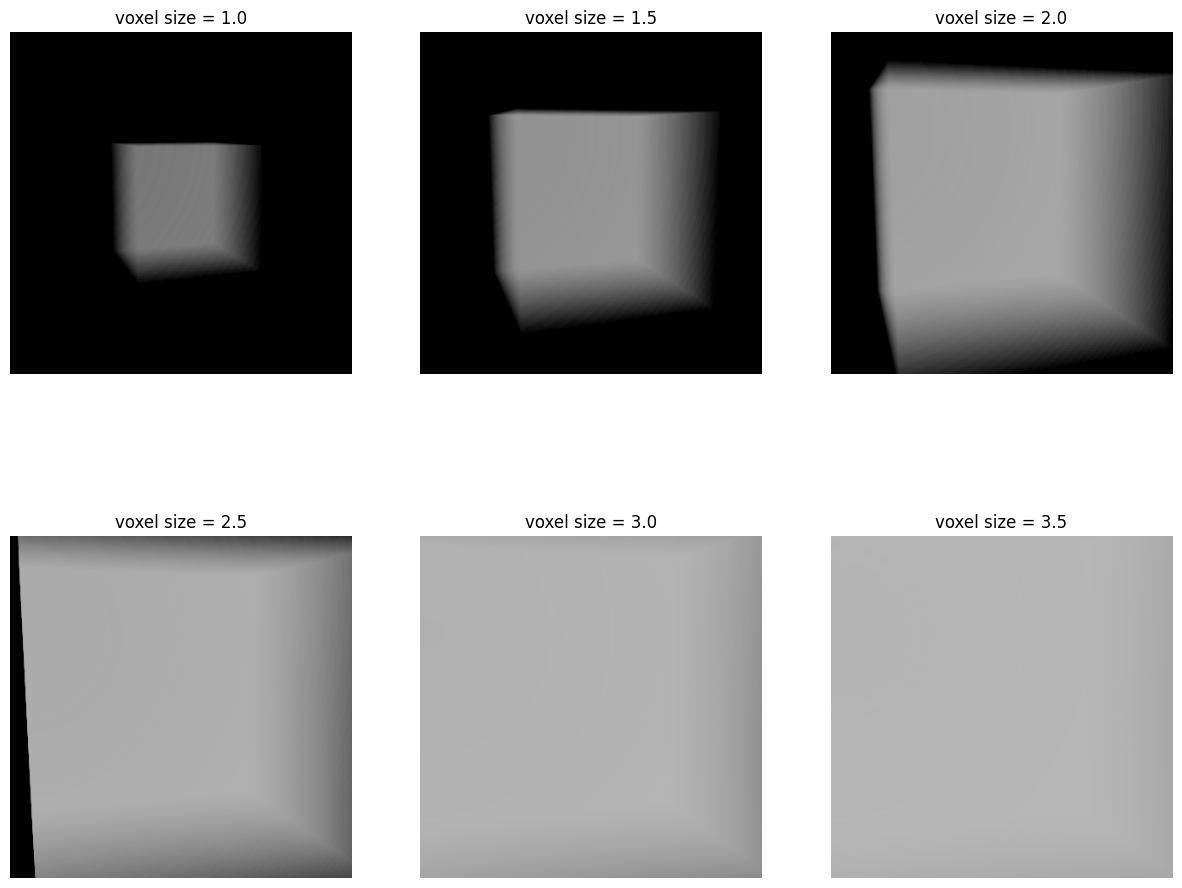

In [9]:
pose_i = 50

# find the voxel size filling the whole screen.
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 12))

camera.matrix = torch.from_numpy(pose[pose_i]).float().to(device)
for i, ax in enumerate(axs.ravel()):
    voxels.size = (i+2)*0.5
    result = renderer.render(tn, tf, n_bins, device)
    ax.imshow(result.reshape(h, w, 3).cpu().detach().numpy())
    ax.set_title(f"voxel size = {voxels.size}")
    ax.axis('off')
plt.show()

In [10]:
# Training function
from tqdm.notebook import tqdm

# train code
def train_model(model, data_loader, losses:list, optimizer, scheduler, n_epochs, tn:float, tf:float, n_bins:int, plot_img:np.ndarray, save_path:str='./data/voxel_{}.pt', device='cpu'):
    for epoch in (range(n_epochs)):
        model.to(device)
        batch_losses = []
        for batch in tqdm(data_loader):
            o = batch[..., 0].to(device)
            d = batch[..., 1].to(device)
            target = batch[..., 2].to(device)
            prediction = model(o, d, tn, tf, n_bins, device)

            # MSE
            loss = ((prediction - target)**2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        scheduler.step()

        loss = np.mean(batch_losses)
        losses.append(loss)

        print(f"Epoch ({epoch+1}/{n_epochs}) - loss : {loss}")
        # plot the test ones
        with torch.no_grad():
            out = model.render(tn, tf, n_bins, device)
        ax = plt.subplot(121)
        ax.axis('off')
        ax.imshow(out.cpu().numpy().reshape(h, w, 3))
        ax = plt.subplot(122)
        ax.axis('off')
        ax.imshow(plot_img)

        plt.show()
        
        # save point
        torch.save(model.cpu(), save_path.format(epoch))

In [11]:
n_epochs = 60
lr = 1e-3
test_pose_i = 30

camera = Camera((w, h, f), torch.from_numpy(test_pose[test_pose_i]).float(), device)
voxels = Voxels(n_voxels, voxel_size, device)
model  = VolumetricRenderer(camera, voxels)


optimizer = torch.optim.Adam(voxels.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(20, n_epochs, 20).tolist(), gamma=0.5)

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (1/60) - loss : 0.12775957685172556


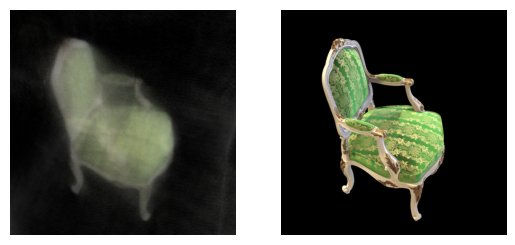

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (2/60) - loss : 0.012441038060456515


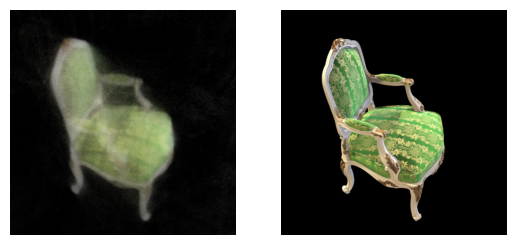

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (3/60) - loss : 0.009274622378200292


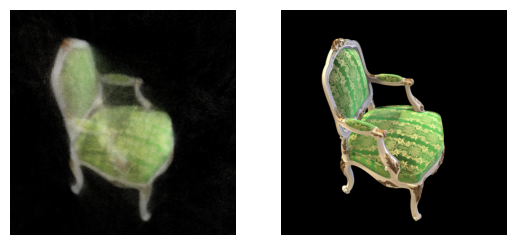

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (4/60) - loss : 0.007824590683192014


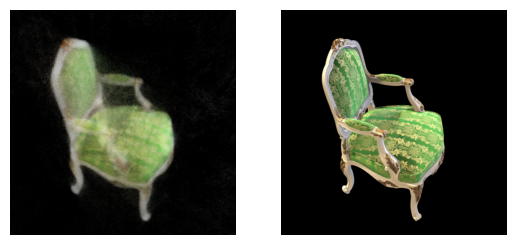

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (5/60) - loss : 0.006894024758428335


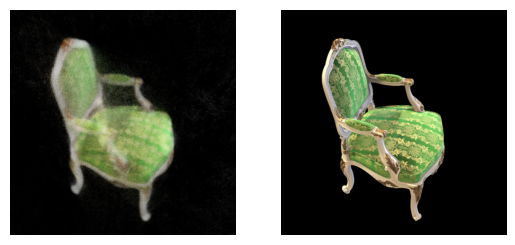

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (6/60) - loss : 0.006212882048815488


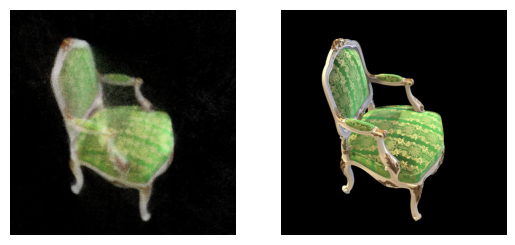

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (7/60) - loss : 0.0056837737285792824


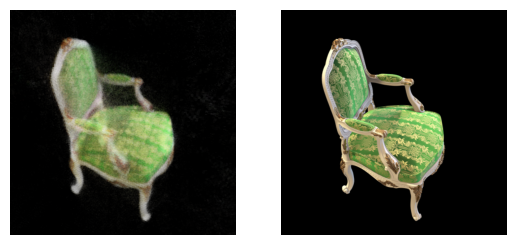

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (8/60) - loss : 0.005262047885835171


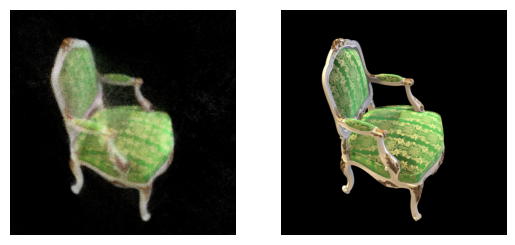

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (9/60) - loss : 0.004920352654859424


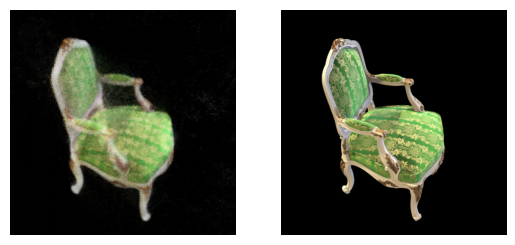

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (10/60) - loss : 0.004639838388249278


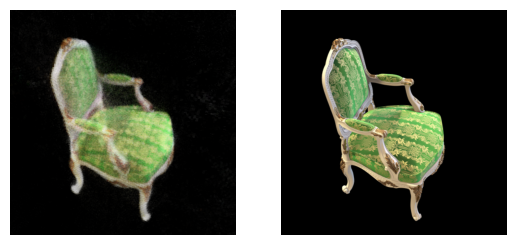

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (11/60) - loss : 0.004406733858332038


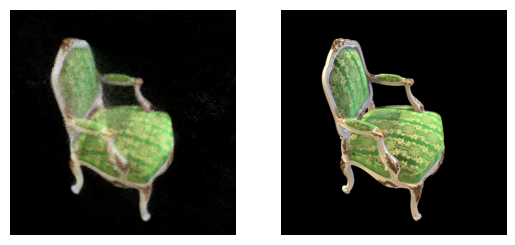

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (12/60) - loss : 0.004210733330443501


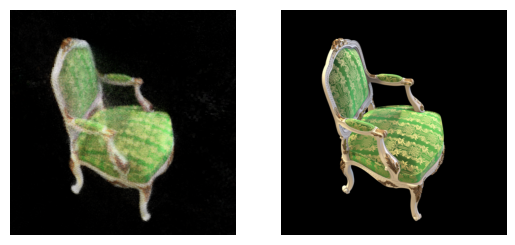

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (13/60) - loss : 0.004044013921543956


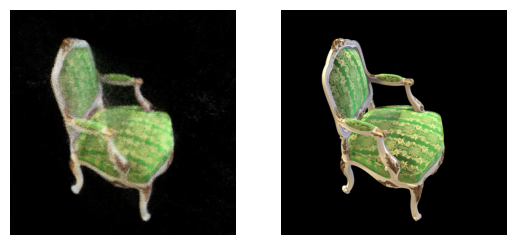

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (14/60) - loss : 0.0039006647588312625


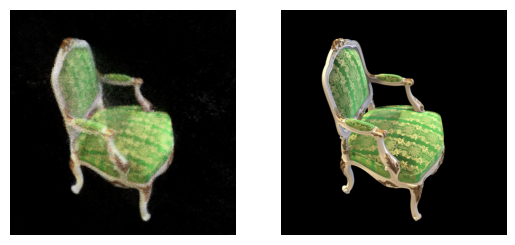

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (15/60) - loss : 0.0037763827624768018


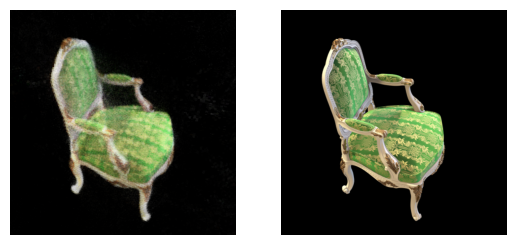

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (16/60) - loss : 0.003667638186454773


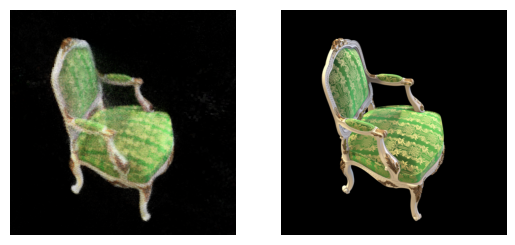

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (17/60) - loss : 0.0035716756732910872


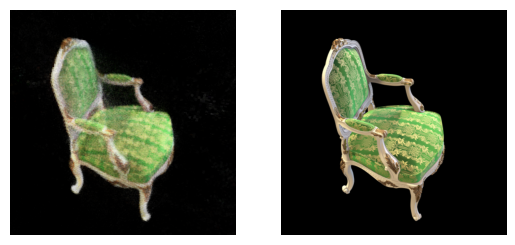

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (18/60) - loss : 0.0034864367696791887


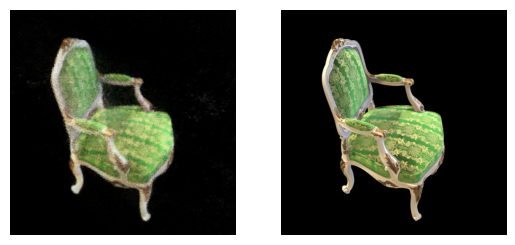

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (19/60) - loss : 0.0034101651556938885


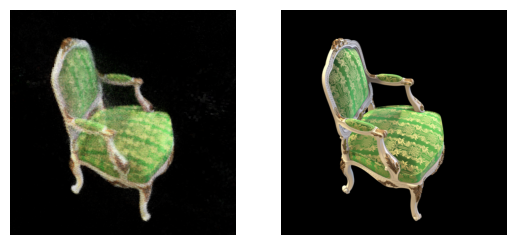

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (20/60) - loss : 0.00334173954872787


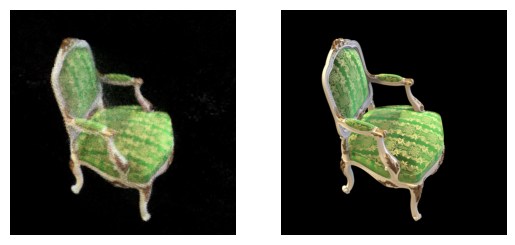

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (21/60) - loss : 0.0032795563547834755


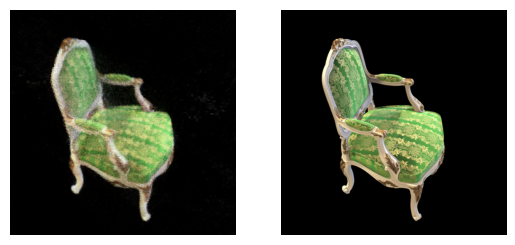

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (22/60) - loss : 0.0032501008729413153


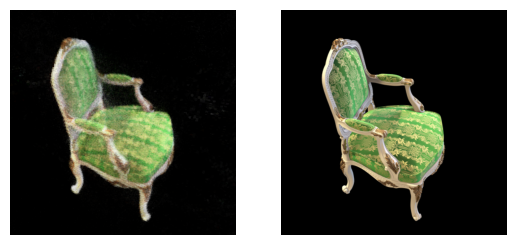

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (23/60) - loss : 0.003221982696868479


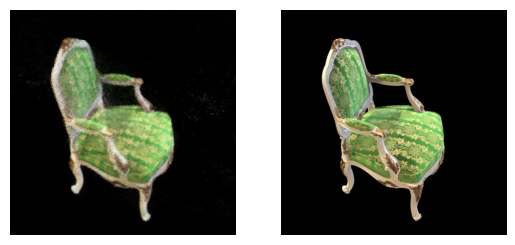

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (24/60) - loss : 0.0031952092615887525


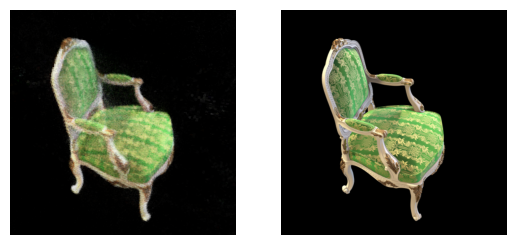

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (25/60) - loss : 0.0031696519422978165


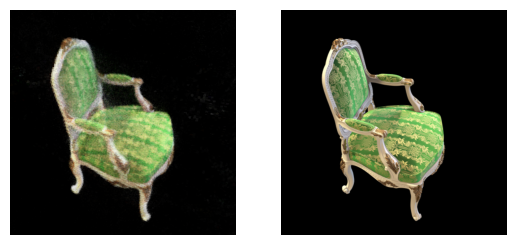

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (26/60) - loss : 0.003145148382127285


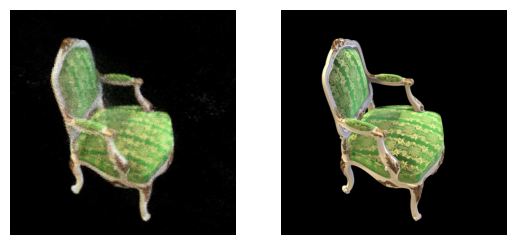

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (27/60) - loss : 0.0031216653077676894


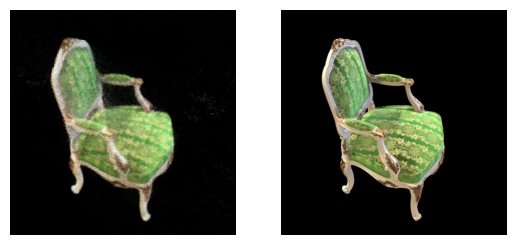

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (28/60) - loss : 0.0030992036399170755


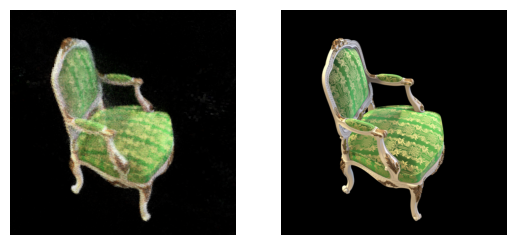

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (29/60) - loss : 0.003077641060553491


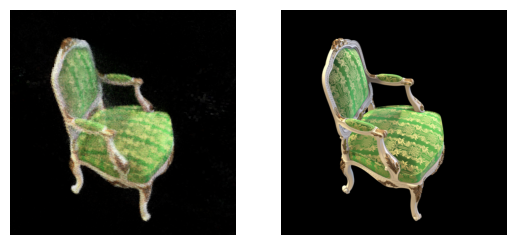

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (30/60) - loss : 0.003056939652748406


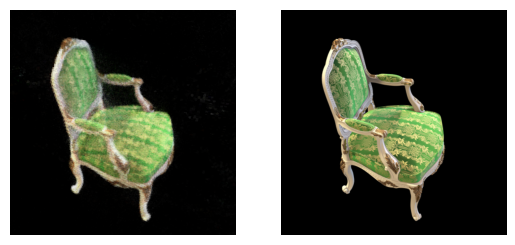

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (31/60) - loss : 0.003036987436495721


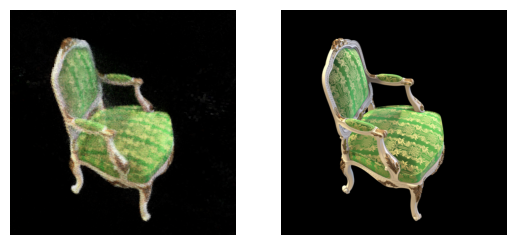

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (32/60) - loss : 0.0030178945290073754


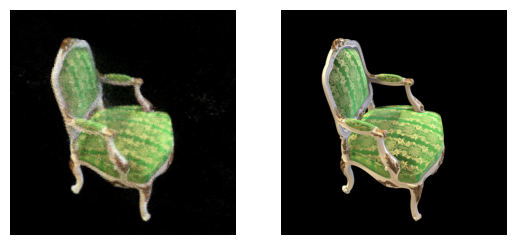

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (33/60) - loss : 0.0029994495429620147


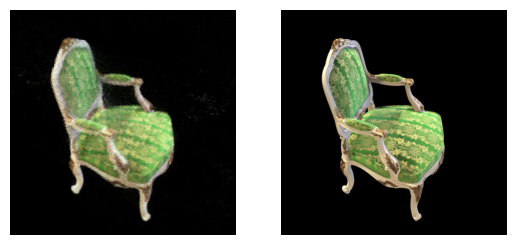

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (34/60) - loss : 0.0029816966862529514


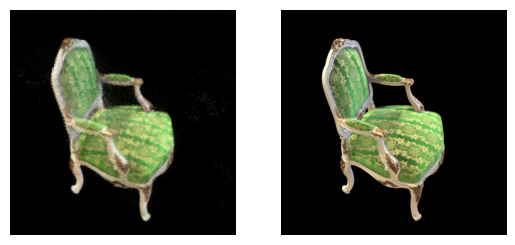

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (35/60) - loss : 0.0029645454975292087


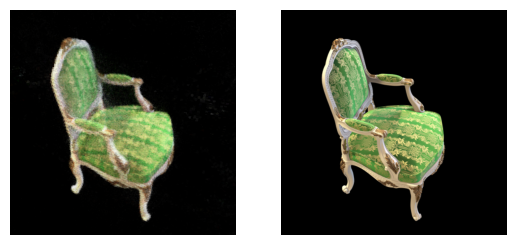

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (36/60) - loss : 0.0029479836264774202


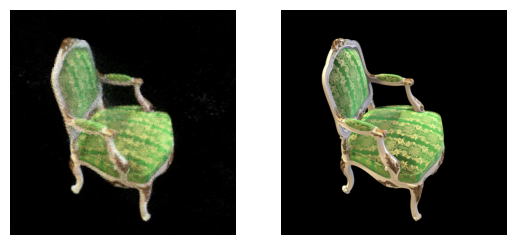

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (37/60) - loss : 0.002932076976761222


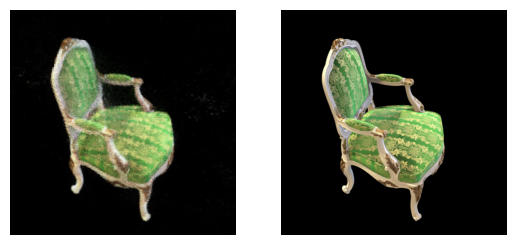

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (38/60) - loss : 0.0029166723580285906


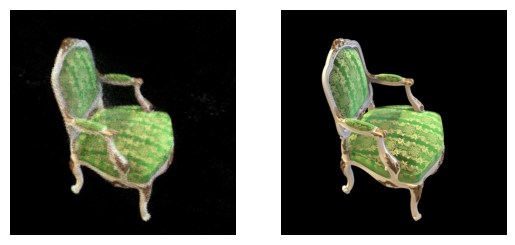

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (39/60) - loss : 0.0029017616760209203


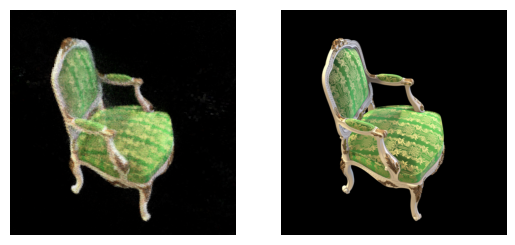

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (40/60) - loss : 0.0028873256799280644


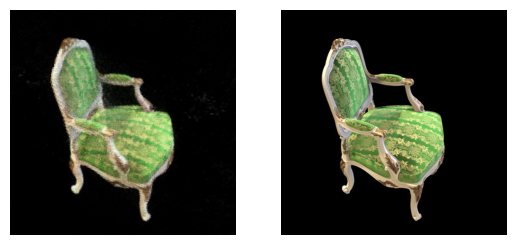

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (41/60) - loss : 0.0028696168713867663


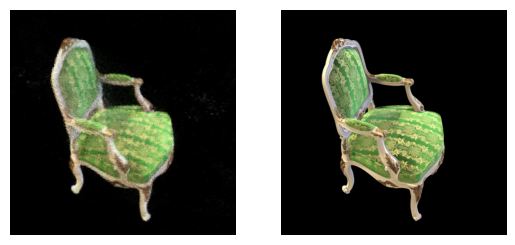

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (42/60) - loss : 0.0028627191061526536


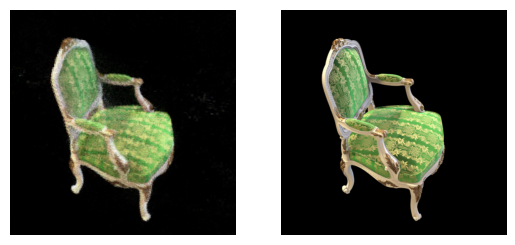

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (43/60) - loss : 0.0028559603782743214


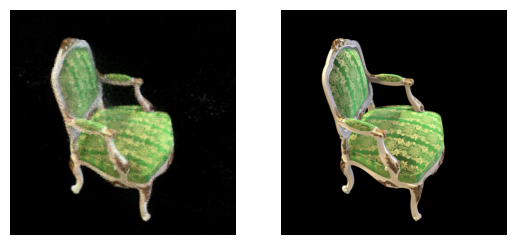

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (44/60) - loss : 0.00284928421612829


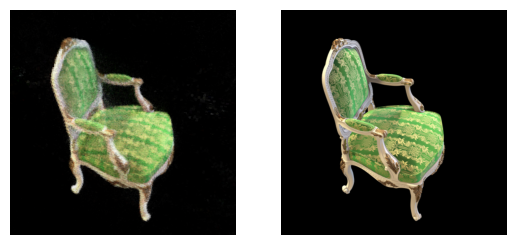

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (45/60) - loss : 0.0028427392190545795


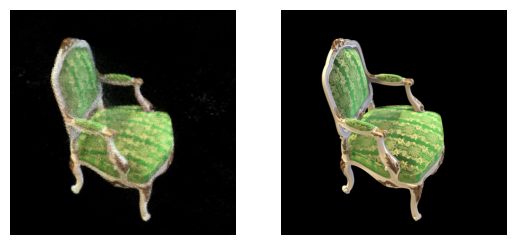

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (46/60) - loss : 0.0028362662432268263


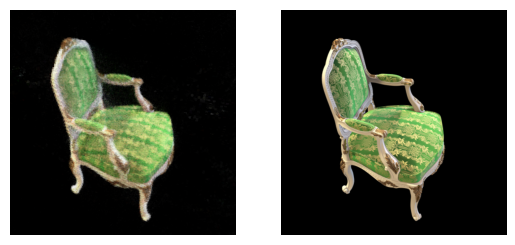

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (47/60) - loss : 0.002829901308000088


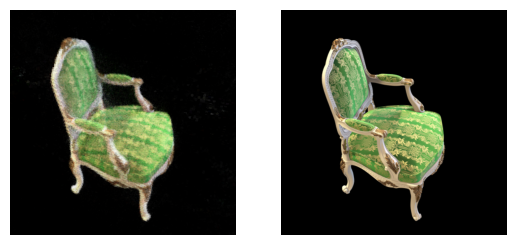

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (48/60) - loss : 0.002823640864059329


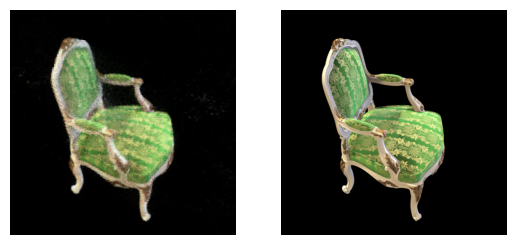

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (49/60) - loss : 0.002817473727270961


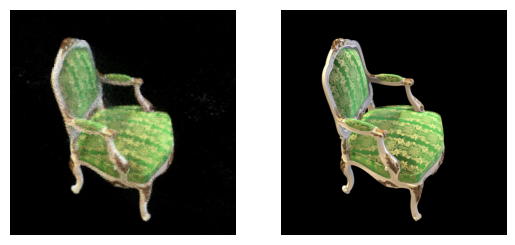

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (50/60) - loss : 0.002811382598645985


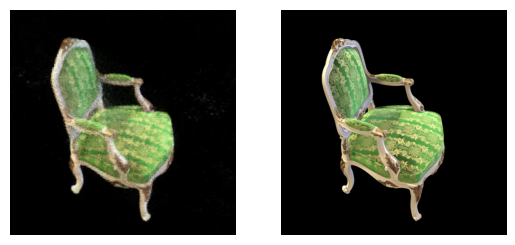

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (51/60) - loss : 0.0028054063640534877


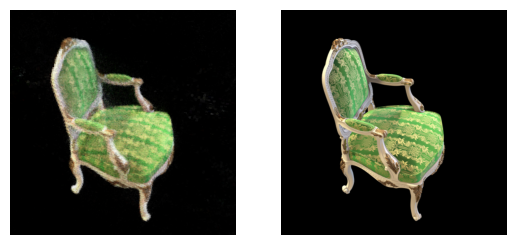

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (52/60) - loss : 0.002799502427458763


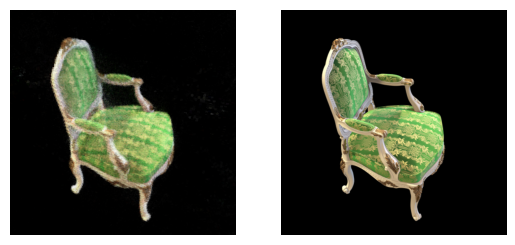

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (53/60) - loss : 0.00279366636569798


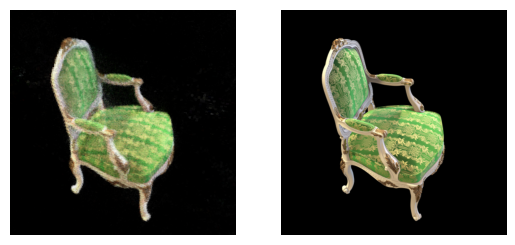

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (54/60) - loss : 0.0027879467963576317


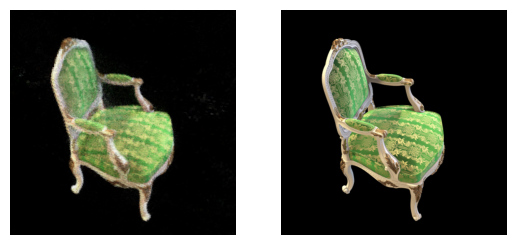

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (55/60) - loss : 0.0027822926304638387


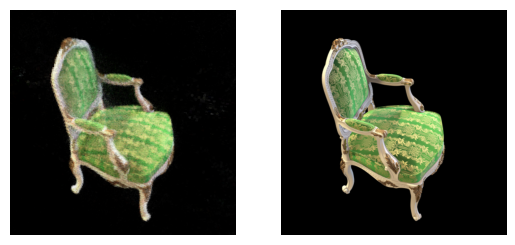

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (56/60) - loss : 0.0027767287239208816


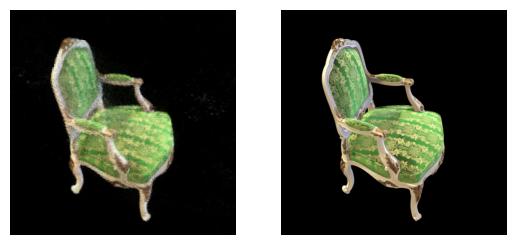

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (57/60) - loss : 0.0027712374479323624


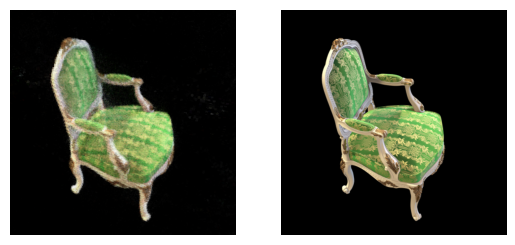

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (58/60) - loss : 0.0027658065915107726


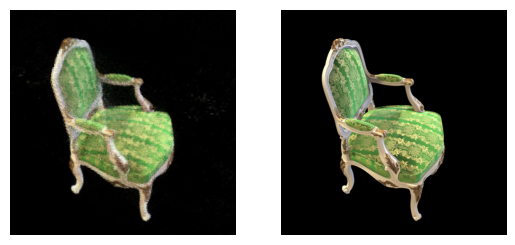

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (59/60) - loss : 0.002760490289323032


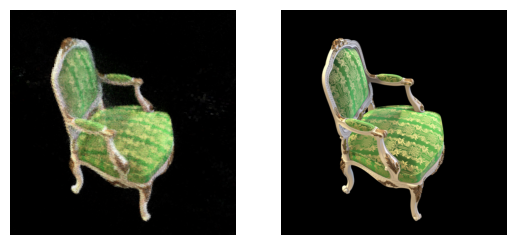

  0%|          | 0/15625 [00:00<?, ?it/s]

Epoch (60/60) - loss : 0.0027552135267481207


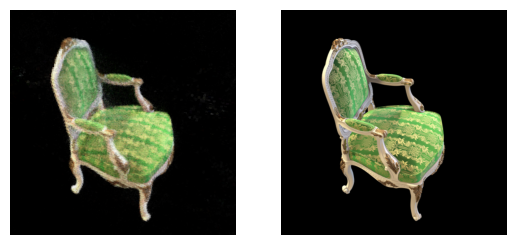

In [105]:
train_losses = []
train_model(model, data_loader, train_losses, optimizer, scheduler, n_epochs, tn, tf, n_bins, plot_img=test_pixels[test_pose_i].numpy().reshape(h, w, 3), device=device)

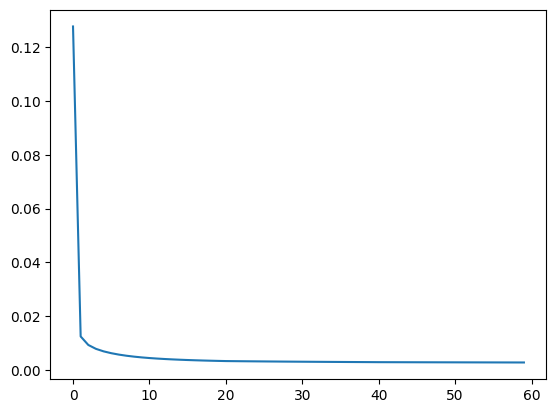

In [106]:
plt.plot(train_losses)
plt.show()

In [25]:
# load model
voxel_model = torch.load('./data/voxel_59.pt').to(device)

n_bins = 200
tn = 4 - voxel_size
tf = 4 + voxel_size

camera = voxel_model.camera

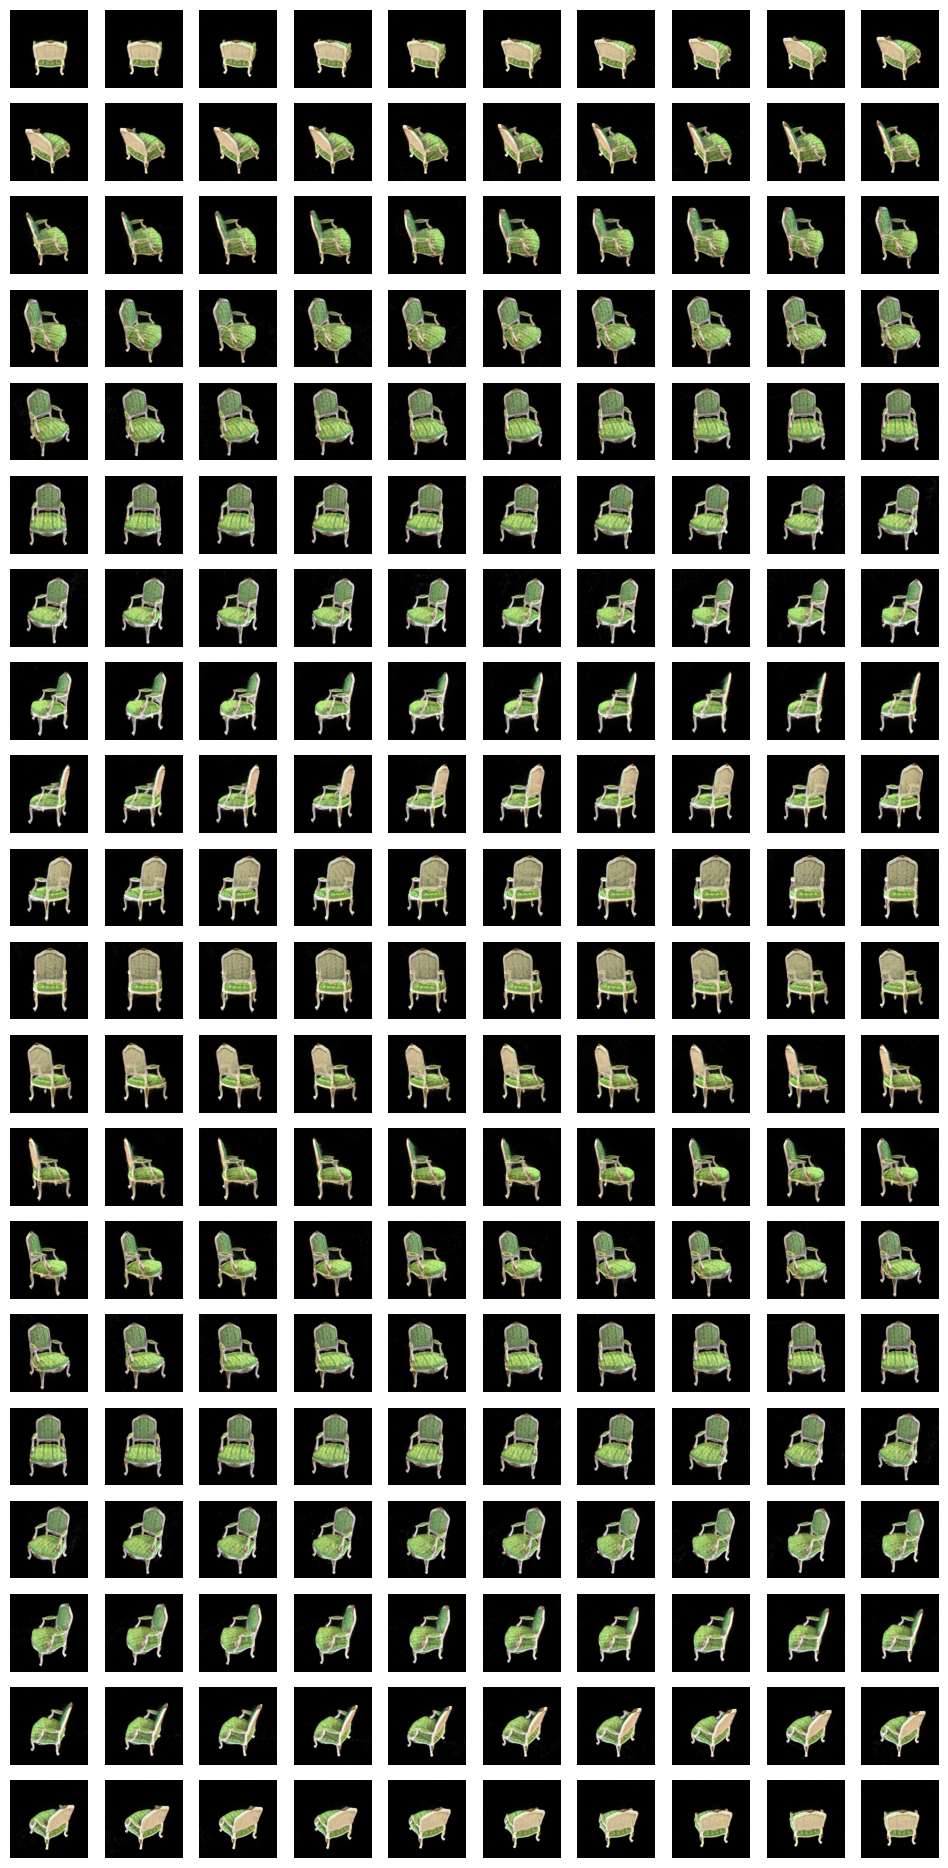

In [37]:
fig, axs = plt.subplots(nrows=20, ncols=10, figsize=(12, 24))

camera.matrix = torch.from_numpy(pose[pose_i]).float().to(device)
images = []
for i, ax in enumerate(axs.ravel()):
    camera.matrix = torch.from_numpy(test_pose[i]).float().to(device)
    result = voxel_model.render(tn, tf, n_bins, device).reshape(h,w,3).cpu().detach().numpy()
    ax.imshow(result)
    ax.axis('off')

    # into 0~255
    images.append((result*255).astype(np.uint8))
plt.show()

In [38]:
import imageio
imageio.mimsave('./img/out_voxel_chairs.gif', images)